In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures # map polynomial features

%matplotlib inline

In [2]:
sns.set(style="ticks", color_codes=True)

### Load Training Set

In [3]:
training_data = DataFrame.from_csv('train_set1.csv', index_col=None)
print(training_data.iloc[:5])

    x_1  x_2       y
0  2104    3  399900
1  1600    3  329900
2  2400    3  369000
3  1416    2  232000
4  3000    4  539900


### Plot Training Set

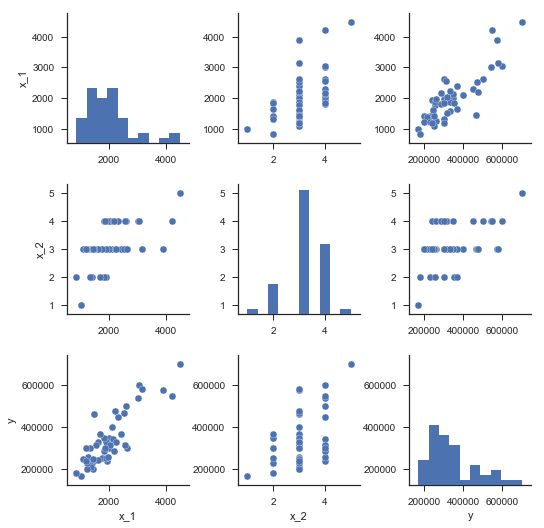

In [4]:
g = sns.pairplot(training_data)

In [5]:
# Used to plot the cost function vs # of iterations
global cf_vs_iter
cf_vs_iter = DataFrame(columns=['J_theta', '# of iterations'])

### Z-Score Normalization

In [6]:
def z_score(val, mu, s):
    return (val-mu)/s

### Features Scaling

Scale the features by taking in the training set, scale the feature columns and return new scaled training set and the scaling factors for each feature column

In [7]:
def feature_scale(training_set):

    scaling_factors = []
    
    # Start scaling the features (Excluding the first column)
    column_names = list(training_set.columns)[1:-1];
    
    for col in column_names:
        s = np.std(training_set[col])
        mu = np.mean(training_set[col])
        training_set[col] = z_score(training_set[col], mu, s)
        
        scaling_factors.append((mu,s))
    
    # Since we're not scaling the first feature, so:
    scaling_factors.insert(0, (0,1))
    
    return [training_set, scaling_factors]

### Basis Function

In [8]:
def basis_func(X):
    
    # Convert the matrix X to type float
    X = X.astype(float)
    
    # For each training example
    for i in range (0, len(X)):
        mean = X[i].mean()
        std = X[i].std()
        p_row = np.exp(-(np.square(X[i]-mean)/(2*(std**2))))
        X[i] = p_row
    
    return X

### Learning Algorithm

Learning algorithm that uses gradient descent algorithm. It takes in the training set, the learning rate, and the number of steps before gradient descent stop. It also takes in the polynomial degree indicating the highest order of the hypothesis function and a hypothesis function generator to return a hypothesis function after finish learning the training set

In [9]:
def learning_algorithm(training_set, learning_rate, steps, polynomial_degree, hypothesis):
    
    # Clear the list for new plot
    global cf_vs_iter
    cf_vs_iter = DataFrame(columns=['J_theta', '# of iterations'])
    
    X = DataFrame.as_matrix(training_set[training_set.columns[:-1]]) # The numpy array excluding output y column
    Y = np.transpose(np.matrix(training_set[training_set.columns[-1]])) # The output vector
    
    # Map polynomials degree
    poly_mapping = PolynomialFeatures(polynomial_degree)
    X = poly_mapping.fit_transform(X)
    training_set = DataFrame(np.concatenate((X, Y), axis=1))
    
    # Scale the feature of the training set
    result = feature_scale(training_set)
    training_set = result[0]
    scaling_factors = result[1]

    # Generate the initial thetas vector
    features_count = len(training_set.columns)-1
    thetas = np.matrix(np.zeros(features_count)).transpose()
    
    X = DataFrame.as_matrix(training_set[training_set.columns[:-1]]) # The dataframe excluding output y
    Y = np.transpose(np.matrix(training_set[training_set.columns[-1]])) # The output vector
    
    # Process matrix X & Y matrix
    X = basis_func(X)
    Y = Y.astype(float)
    
    for i in range(0, steps):
        
        estimated = X*thetas # estimated outputs
        
        # difference between estimated output and training output
        residual = estimated - Y
        
        # Update thetas
        thetas = np.matrix(thetas)-learning_rate*(np.transpose(X)*residual)

        # Compute cost for plotting
        cost = np.sum(np.square(residual))/ 2 # Compute the cost
        cf_vs_iter = cf_vs_iter.append(DataFrame([[cost,i]], columns=['J_theta', '# of iterations']), ignore_index=True)
        
    print(thetas)
    def h(inputs):
        return hypothesis(thetas, inputs, scaling_factors)
    
    return h

### Hypothesis Function Generator

In [10]:
def hypothesis_creator(polynomial_degree):
    
    def hypothesis(thetas, features, scaling_factors):
        
        # Map polynomials degree
        poly_mapping = PolynomialFeatures(polynomial_degree)
        features = poly_mapping.fit_transform(np.array([features]))
        features = list(features)[0]
        
        # Scale the features
        for i in range(0, len(features)):
            features[i] = z_score(features[i], scaling_factors[i][0], scaling_factors[i][1])    
                
        return np.sum(np.matrix(features)*thetas)
    
    return hypothesis

### Polynomial degree

In [11]:
# For a linear hypothesis, polynomial degree = 1
k = 2

In [12]:
# Create the hypothesis model
h = hypothesis_creator(k)

### Run Gradient Descent

In [13]:
# Run gradient descent algorithm
hypothesis = learning_algorithm(training_set=training_data, 
                                learning_rate=0.3, 
                                steps=100, 
                                polynomial_degree=k, 
                                hypothesis=h)

[[ -7.54869842e+167]
 [ -1.83875640e+168]
 [ -1.86874965e+168]
 [ -1.83396727e+168]
 [ -2.10225590e+168]
 [ -1.82921924e+168]]


/Users/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square


### Plot Cost Function over Each Iteration

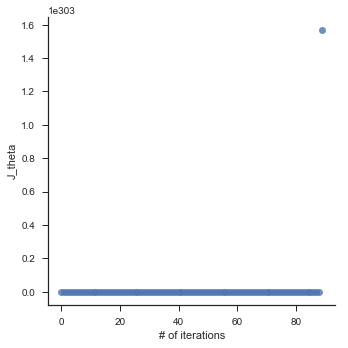

In [14]:
# Plot cost function vs # iterations
plot = sns.lmplot(x="# of iterations", y="J_theta",data=cf_vs_iter, fit_reg=False)

### Test The Hypothesis Function

In [15]:
print("Predicted price of a 1650 sq-ft, 3 br house (using gradient descent):")
print("$",hypothesis([1650,3]))

Predicted price of a 1650 sq-ft, 3 br house (using gradient descent):
$ 2.91197157067e+168
